# Предсказание отрасли компании

На основе данных о транзакциях между 2 компаниями, для пропущенных значений отрасли компании необходимо создать предиктивную модель, предсказывающую отрасль компании


Загрузка необходимых библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.simplefilter('ignore')
from sklearn.preprocessing import StandardScaler

Загрузка 2 датасетов:
1. pays- датасет с суммой, частотой и неделей совершения платежей между 2 компаниями, представленными в виде обезличенного ИНН.
2. innInfo- датасет с информацией (такой как отрасль `okved2` и регион) по каждой отдельной компании.

In [2]:
innInfo = pd.read_csv('https://www.dropbox.com/s/5aztgcxa5euubn4/inn_info_public.csv?dl=1')
pays = pd.read_csv('https://www.dropbox.com/s/7if97r10dc2i441/pays.csv?dl=1')

Посмотрим на первые 5 столбцов каждого датасета

In [3]:
innInfo.head()

,hash_inn,okved2,region,is_public
0,61058,34,86,True
1,8311,18,86,True
2,130273,-1,86,False
3,64081,43,86,True
4,218005,12,86,True


In [4]:
pays.head()

,hash_inn_kt,hash_inn_dt,week,count,sum
0,0,0,1,4,38399.6
1,0,0,5,2,399.6
2,0,0,7,2,79.6
3,0,0,9,2,239.6
4,0,0,12,2,79.6


Размер датасетов `innInfo` и `pays` составляет (240069, 4) и (5429025, 5) соответственно. В датасете `innInfo` содержится информация о уникальных ИНН, отрасли компании и регионе. Все переменные являются категориальными (qualitative). В датасете `pays` содержится информция о повторяющихся ИНН, неделе совершения платежа, количестве платежей в неделю и сумме платежей в неделю. Переменные `week`, `count` и `sum` являются количественными (quantitative). Зависимой переменной, которую необходимо предсказать является `okved2`.

## Предварительная обработка данных

Для обучения модели необходимо объединить данные из датасетов `innInfo` и `pays` в единый датасет. Переменные `hash_inn`, `hash_inn_kt`, `hash_inn_dt` и `region` являются категориальными. Поскольку уникальных значений ИНН составляет 240069, а для региона 80, использование OheHotEncoding для представления каждого значения в виде dummy variables увеличит количество столбцов в едином датасете на 240149. Поэтому необходимо сделать предобработку данных.

Последний столбец `is_public` датасета `innInfo` содержит метки для разбиения на тренировочную и тестовую выборки. Аналогичная информация содержится в переменной `okved2`, где меткой для тестовой выборки служит значение `-1`. Удалим столбец `is_public`, содержащий избыточную информацию, а также строчки с пропущенными значениями `sum`

In [5]:
innInfo.drop('is_public', axis=1, inplace=True)
pays.dropna(inplace=True)

Применим к переменной `pays` линейное преобразование $250pays+100$ для получения неотрицательных целых значений. Десятые доли необходимы для избежания нулевых значений

In [6]:
pays['sum'] = pays['sum']*250 + 100

### Агрегирование данных по платежам

В датасете `pays` переменная `week`- неделя совершения платежа, `count`- количество платежей в неделю, `sum`- объем платежей в неделю. Трансформируем вышеуказанные переменные:
1.  weeksAmount- число недель в которых проводились платежи
2.  averageCount- среднее число платежей за весь период
3. averageSum- средняя величина транзакции за весь период

In [7]:
pays['sum'] = pays['sum']/pays['count']

paysAggregated = pays.groupby(by=("hash_inn_kt", "hash_inn_dt")).agg({
    'week': np.size, 'count': np.mean, 'sum': np.mean})
paysAggregated.reset_index(inplace=True)

paysAggregated.rename(columns={'week': 'weeksAmount', 'count': 'averageCount', 'sum': 'averageSum'},
            inplace=True)

paysAggregated.head()

,hash_inn_kt,hash_inn_dt,averageSum,weeksAmount,averageCount
0,0,0,273024.000000,10,2.600000
1,0,7212,62783.964286,7,2.285714
2,0,11703,365800.000000,1,1.000000
3,0,25395,8373.333333,1,3.000000
4,0,34686,91476.000000,2,2.500000


### Агрегирование данные по исходящим платежам

Цель преобразования- избавиться от категориальных переменных ИНН, отсортировав датасет по возрастанию значений ИНН. Таким образом, итоговый датасет будет состоять из 240069 строк как и `innInfo`, и, упорядочив датасет `innInfo` по полю `hash_inn`, i-ая строка будет совпадать в обоих датасетах

In [8]:
Out = pd.merge(paysAggregated, innInfo[['hash_inn', 'region']], left_on='hash_inn_dt', right_on='hash_inn',
              sort=True)
Out.drop('hash_inn', axis=1, inplace=True)

Out = Out.groupby(by=('hash_inn_kt'), sort=False).agg({
    'weeksAmount': 'mean',
    'averageCount': 'mean',
    'averageSum': 'mean',
    'hash_inn_dt': 'size',
    'region': lambda x: x.nunique()
})
Out.reset_index(inplace=True)

Out.rename(columns={'hash_inn_kt': 'hash_inn',
                    'weeksAmount': 'weeksAmountOut',
                    'averageCount': 'averageCountOut',
                    'averageSum': 'averageSumOut',
                    'hash_inn_dt': 'innCountOut',
                    'region': 'regionsCountOut',
                    }, inplace=True)

Out = pd.merge(Out, innInfo[['hash_inn']], on='hash_inn', how='outer', sort=True)
Out.fillna(0 ,inplace=True)
Out.drop('hash_inn', axis=1, inplace=True)

Out.head()

,innCountOut,regionsCountOut,averageCountOut,weeksAmountOut,averageSumOut
0,34.0,15.0,1.919024,2.500000,167699.451718
1,1.0,1.0,2.000000,7.000000,2514.285714
2,3.0,3.0,1.666667,1.000000,1815.833333
3,1.0,1.0,1.000000,1.000000,3587.000000
4,6.0,1.0,1.033333,2.833333,232.250000


`weeksAmout`, `averageCount`, `averageSum` были агрегированы с точность до `hash_inn_kt`  
`innCount` — число различных инн, которым был перечислен платеж для каждого `hash_inn_kt`  
`regionsCount` — число различных регионов, в которые были осуществлены платежи для каждого `hash_inn_kt`

### Агрегирование данные по входящим платежам

In [9]:
In = pd.merge(paysAggregated, innInfo[['hash_inn', 'region']], left_on='hash_inn_kt', right_on='hash_inn',
              sort=True)
In.drop('hash_inn', axis=1, inplace=True)

In = In.groupby(by=('hash_inn_dt'), sort=False).agg({
    'weeksAmount': 'mean',
    'averageCount': 'mean',
    'averageSum': 'mean',
    'hash_inn_kt': 'size',
    'region': lambda x: x.nunique()
})
In.reset_index(inplace=True)

In.rename(columns={'hash_inn_dt': 'hash_inn',
                    'weeksAmount': 'weeksAmountIn',
                    'averageCount': 'averageCountIn',
                    'averageSum': 'averageSumIn',
                    'hash_inn_kt': 'innCountIn',
                    'region': 'regionsCountIn',
                    }, inplace=True)

In = pd.merge(In, innInfo[['hash_inn', 'okved2']], on='hash_inn', how='outer', sort=True)
In.fillna(0 ,inplace=True)
In.drop('hash_inn', axis=1, inplace=True)

In.head()

,innCountIn,averageCountIn,weeksAmountIn,averageSumIn,regionsCountIn,okved2
0,144.0,2.09405,3.104167,28074.012083,21.0,-1
1,0.0,0.00000,0.000000,0.000000,0.0,62
2,1.0,2.90000,10.000000,3976.810000,1.0,-1
3,0.0,0.00000,0.000000,0.000000,0.0,29
4,0.0,0.00000,0.000000,0.000000,0.0,-1


### Дополнительные сведения

О платежах между совпадаюшими инн (`hash_inn_kt` = `hash_inn_dt`). Добавим бинарный столбец `selfPayment`, принимающий значение 1 для случаев, когда платеж совершен внутри организации

In [10]:
Inner = paysAggregated[paysAggregated['hash_inn_kt'] == paysAggregated['hash_inn_dt']]
Inner['selfPayment'] = np.ones(Inner.shape[0])
Inner.drop(['hash_inn_dt', 'weeksAmount', 'averageCount', 'averageSum'], axis=1, inplace=True)
Inner.rename(columns={'hash_inn_kt': 'hash_inn'}, inplace=True)
Inner = pd.merge(Inner, innInfo[['hash_inn']], on='hash_inn', how='outer', sort=True)
Inner.fillna(0 ,inplace=True)
Inner.drop('hash_inn', axis=1, inplace=True)

О платежах с нулевыми суммами (взаимозачет). Добавим бинарные столбцы `zeroSumOut` и `zeroSumIn`, принимающий значение 1 для случаев, когда платеж совершен внутри организации

In [11]:
zeroSum = pays[pays['sum'] == 0]

zeroSumOut = zeroSum.groupby(by='hash_inn_kt').agg({'hash_inn_kt':lambda x:x.nunique()})
zeroSumOut.rename(columns={'hash_inn_kt': 'zeroSumOut'}, inplace=True)
zeroSumOut.reset_index(inplace=True)
zeroSumOut.rename(columns={'hash_inn_kt': 'hash_inn'}, inplace=True)

zeroSumIn = zeroSum.groupby(by='hash_inn_dt').agg({'hash_inn_dt':lambda x:x.nunique()})
zeroSumIn.rename(columns={'hash_inn_dt': 'zeroSumIn'}, inplace=True)
zeroSumIn.reset_index(inplace=True)
zeroSumIn.rename(columns={'hash_inn_dt': 'hash_inn'}, inplace=True)

zeroSumOut = pd.merge(zeroSumOut, innInfo[['hash_inn']], on='hash_inn', how='outer', sort=True)
zeroSumOut.fillna(0 ,inplace=True)
zeroSumOut.drop('hash_inn', axis=1, inplace=True)

zeroSumIn = pd.merge(zeroSumIn, innInfo[['hash_inn']], on='hash_inn', how='outer', sort=True)
zeroSumIn.fillna(0 ,inplace=True)
zeroSumIn.drop('hash_inn', axis=1, inplace=True)

Объединение в единый датасет

In [12]:
df = pd.concat([Out, In, Inner, zeroSumOut, zeroSumIn], axis=1)

In [13]:
df.head()

,innCountOut,regionsCountOut,averageCountOut,weeksAmountOut,averageSumOut,innCountIn,averageCountIn,weeksAmountIn,averageSumIn,regionsCountIn,okved2,selfPayment,zeroSumOut,zeroSumIn
0,34.0,15.0,1.919024,2.500000,167699.451718,144.0,2.09405,3.104167,28074.012083,21.0,-1,1.0,0.0,0.0
1,1.0,1.0,2.000000,7.000000,2514.285714,0.0,0.00000,0.000000,0.000000,0.0,62,0.0,0.0,0.0
2,3.0,3.0,1.666667,1.000000,1815.833333,1.0,2.90000,10.000000,3976.810000,1.0,-1,0.0,0.0,0.0
3,1.0,1.0,1.000000,1.000000,3587.000000,0.0,0.00000,0.000000,0.000000,0.0,29,0.0,0.0,0.0
4,6.0,1.0,1.033333,2.833333,232.250000,0.0,0.00000,0.000000,0.000000,0.0,-1,0.0,0.0,0.0


## Предварительный анализ

Разбиение датасета на обучающую выборку `train_df` и тестовой `test_df` выборки по флагу `okved2` = -1

In [14]:
train_df = df[df['okved2'] != -1]
test_df = df[df['okved2'] == -1]

### Baseline

Распределение значений зависимой переменной `okved2`

In [15]:
train_df['okved2'].value_counts().head()

12    44918
34    13654
14    10179
4      7617
52     6986
Name: okved2, dtype: int64

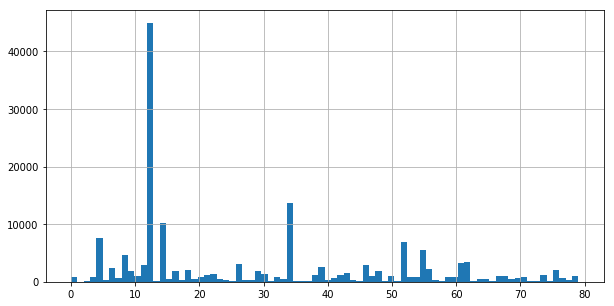

In [16]:
train_df['okved2'].hist(bins=train_df['okved2'].nunique(), figsize=(10,5));

Из гистограммы распределения видно, что большинство значений `okved2` принадлежат 12 классу. Наивный классификатор, всегда относящий наблюдение к ОКВЭД 12 будет точен в 28% случаев, поэтому baseline нашей модели = 0.28

In [17]:
train_df['okved2'].value_counts().max()/train_df['okved2'].shape[0]

0.27827649227147416

### Корреляция

In [18]:
train_df.corr()

,innCountOut,regionsCountOut,averageCountOut,weeksAmountOut,averageSumOut,innCountIn,averageCountIn,weeksAmountIn,averageSumIn,regionsCountIn,okved2,selfPayment,zeroSumOut,zeroSumIn
innCountOut,1.000000,0.439841,0.064751,0.066642,-0.000741,0.381247,0.038037,0.025067,0.001756,0.274811,-0.008708,0.118318,0.219905,0.096073
regionsCountOut,0.439841,1.000000,0.264231,0.216077,0.019893,0.552617,0.046834,0.012161,0.000382,0.593662,-0.022621,0.321821,0.190285,0.122365
averageCountOut,0.064751,0.264231,1.000000,0.514556,0.069806,0.166033,0.091909,-0.064315,0.018402,0.184869,-0.017464,0.269357,0.041696,0.055161
weeksAmountOut,0.066642,0.216077,0.514556,1.000000,0.052005,0.141037,-0.048707,-0.023474,-0.000589,0.136693,-0.045530,0.198611,0.043221,0.049230
averageSumOut,-0.000741,0.019893,0.069806,0.052005,1.000000,0.036964,0.008982,-0.010912,0.106137,0.035582,0.004623,0.058106,0.002785,0.010033
innCountIn,0.381247,0.552617,0.166033,0.141037,0.036964,1.000000,0.135656,0.104046,0.007783,0.797176,0.028294,0.390514,0.200333,0.201097
averageCountIn,0.038037,0.046834,0.091909,-0.048707,0.008982,0.135656,1.000000,0.395500,0.051270,0.268013,0.009830,0.183091,0.024148,0.047434
weeksAmountIn,0.025067,0.012161,-0.064315,-0.023474,-0.010912,0.104046,0.395500,1.000000,0.020146,0.182977,-0.030990,0.078584,0.012821,0.038992
averageSumIn,0.001756,0.000382,0.018402,-0.000589,0.106137,0.007783,0.051270,0.020146,1.000000,0.017993,0.002127,0.026824,0.003118,0.002917
regionsCountIn,0.274811,0.593662,0.184869,0.136693,0.035582,0.797176,0.268013,0.182977,0.017993,1.000000,0.020503,0.456072,0.155798,0.176134


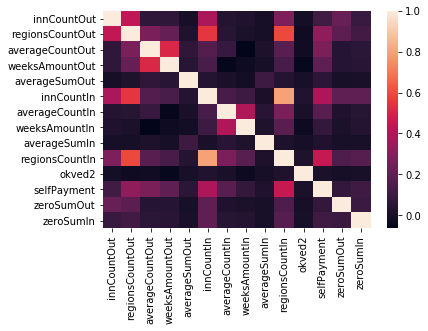

In [19]:
sns.heatmap(train_df.corr());

## Machine Learning

Разбиение датасета `train_df` на обучающую `X_train`, тестовую/валидационную `X_test` выборки, а также на метки `okved2` классов `y_train` `y_test`. Отношение обучающей и тестовой выборок равно 0.2. Предсказание классов для наилучшей с точки зрения метрики качества модели будем смотреть на отложенной выборке `test_df`

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    train_df.loc[:,train_df.columns != 'okved2'], train_df['okved2'], test_size=0.2, random_state=17)

### Decision tree

Функцией потерь в модели будет являеться `Gini index`, деревья строятся максимально возможной глубины

In [21]:
%%time
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
tree_pred = tree.predict(X_test)

CPU times: user 3.45 s, sys: 58.3 ms, total: 3.51 s
Wall time: 3.51 s


In [22]:
accuracy_score(y_test, tree_pred)

0.14617600594740265

Accuracy модели `0.143`

### Balanced tree

Из гистограммы распределения классов переменной `okved2` видно, что ее значения распределены неравномерно. Удельный вес 12 класса составляет 30%. 34 класса-7%, 4 класса- 7%. Переменная `okved2` принимает значения из 3 классов в 45% случаев. При построении дерева обучающие данные для разных классов подаются неравномерно, что сказывается как на точности предсказания модели в общем и на предсказании классов с маленький удельным весом в частности. Для решения этой проблемы необходимо применять балансировку. Ее суть заключается в том, что данные из разных классов подаются равномерно вне зависимости от удельного веса

In [23]:
%%time
tree = DecisionTreeClassifier(class_weight='balanced')
tree.fit(X_train, y_train)
tree_pred = tree.predict(X_test)

CPU times: user 4.59 s, sys: 46.9 ms, total: 4.64 s
Wall time: 4.64 s


In [24]:
accuracy_score(y_test, tree_pred)

0.12746646841991141

Accuracy модели снизился до `0.128`

In [25]:
# функция для построение графика вклада переменных
def featureImportances(model, title) :
    importances = model.feature_importances_
    indices = np.arange(len(X_train.columns))
    
    plt.figure(figsize=(10,5))
    plt.title(title)
    plt.barh(range(len(indices)), importances[indices], color='g', align='center')
    plt.yticks(range(len(indices)), (X_train.columns));

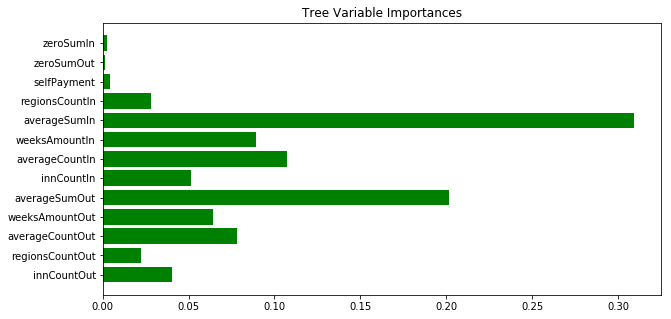

In [26]:
featureImportances(tree, 'Tree Variable Importances')

Максимальный вклад в предсказательную точность вносят переменные `averageSumIn` и `AverageSumOut`

### Random Forest

In [27]:
%%time
rf = RandomForestClassifier(n_estimators=20, class_weight='balanced')
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

CPU times: user 16.2 s, sys: 21.7 s, total: 37.9 s
Wall time: 38 s


In [28]:
accuracy_score(y_test, rf_pred)

0.21900071244927671

Accuracy 0.22

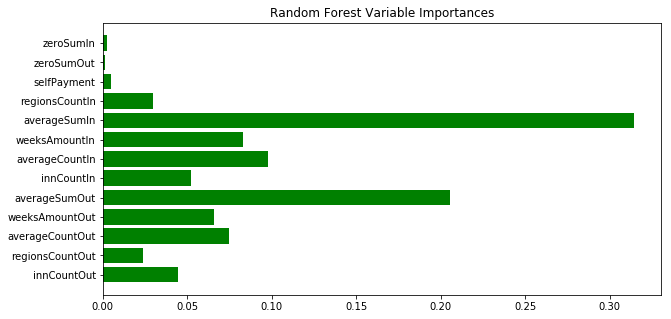

In [29]:
featureImportances(rf, 'Random Forest Variable Importances')

Случайный лес показал примерно аналогичный вклад каждой переменной как и в деревьях решений

### KNN

Перед использованием метода ближайших соседей, необходимо стандартизировать датасеты `X_train` и `X_test`, т.е. привести каждую независимую переменную к математическому ожидания 0 и дисперсии 1

In [30]:
scaler = StandardScaler().fit(X_train)

In [31]:
scaler.mean_

array([  6.31719481e+00,   1.44727101e+00,   1.35879082e+00,
         1.99495331e+00,   1.81008053e+04,   6.30116470e+00,
         1.64540414e+00,   2.56899701e+00,   1.36172261e+04,
         1.82665025e+00,   7.23058576e-02,   4.87872874e-03,
         9.71099340e-03])

In [32]:
scaler.scale_

array([  4.98981251e+01,   3.02999999e+00,   1.64874678e+00,
         2.74634968e+00,   1.79718959e+05,   2.05492582e+01,
         1.41184035e+00,   3.08059852e+00,   9.40819532e+04,
         2.77212619e+00,   2.58993669e-01,   6.96773044e-02,
         9.80647236e-02])

In [33]:
scale_X_train = scaler.transform(X_train)
scale_X_test = scaler.transform(X_test)

In [34]:
%%time
knn = KNeighborsClassifier()
knn.fit(scale_X_train, y_train)
knn_pred = knn.predict(scale_X_test)

CPU times: user 31 s, sys: 25 ms, total: 31 s
Wall time: 30.9 s


In [35]:
accuracy_score(y_test, knn_pred)

0.21463308862249481

Accuracy 0.21

Поиск лучшего гиперпараметра `n_neighbors` минимизирующего целевую функцию, будем искать по сетке различных гиперпараметров. Ошибка вычисляется на 5-fold кросс-валидации

In [36]:
tuned_param_knn = {'n_neighbors': np.arange(10, 25)}

In [37]:
knn_cv = GridSearchCV(knn, tuned_param_knn, cv=5, scoring='accuracy', n_jobs=-1)

In [38]:
#%%time
#knn_cv.fit(scale_X_train, y_train)

In [39]:
#knn_cv.best_estimator_

In [ ]:
#knn_cv.best_score_

Accuracy 0.28

### Logit

In [ ]:
logit = LogisticRegression(n_jobs=-1, random_state=17, solver='lbfgs', class_weight='balanced')
logit.fit(scale_X_train, y_train)
logit_pred = logit.predict(scale_X_test)
accuracy_score(y_test, logit_pred)

Accuracy 0.04

In [ ]:
tuned_param_logit = {'C': np.array([1e-05, 1e-04, 1e-03, 1e-02, 0.1])}

In [ ]:
logit_cv = GridSearchCV(logit, tuned_param_logit, cv=5, scoring='accuracy', n_jobs=-1)

In [ ]:
#%%time
#logit_cv.fit(scale_X_train, y_train)

In [ ]:
#logit_cv.best_estimator_.C

In [ ]:
#logit_cv.best_score_

Accuracy 0.05

Как видно, все вышеприведенные предсказания получаются значительно ниже baseline. В случае, когда балансировка не применяется `class_weight='none'`, значения accuracy очень близки к baseline и не зависят от регуляризации. Это объясняется тем, что данные для обучения отбираются неравномерно и почти все данные, подающиеся на обучение, состоят из 12 класса, удельный вес которог окак раз и получается равным 0.28

## Бинарная классификация

Альтернативный вариант- последовательное построение бинарных классификаторов.
1. В датасете `train_df` метки 12 класса для `okved2` остаются без изменений, остальные заменяются -2 (поскольку 0 ОКВЭД присутствует в датасете). Таким образом бинарная классификация происходит между 12 и всеми остальными классами.
2. Предсказав наилучший результат с т.з. метрики качества, для данной модели предсказывается вектор `y` с метками 0 и 12 на отложенной выборке и результат сохраняется.
3. Из датасета `train_df` отбрасываются наблюдения (строчки) с 12 классом и алгоритм повторяется для наиболее часто встречаемого из оставшихся классов (34, после 14)
4. Для оставшихся классов с маленьким удельными весом строится мультиклассовая классификация и предсказанные значения на отложенной выборке также сохраняются в вектор `y`.
5. Accuracy модели считается для каждой классификации, а суммарная точность берется как взвешенная сумма (в зависимости от размера предсказываемого класса в исходной выборке)
6. Итоговый вектор с метками классов `okved2` компануется из векторов `y` и сохраняется в submission file

### 12 и остальные классы

In [ ]:
# сортировка innInfo по ИНН. df уже отсротирован по возрастанию
innInfo = innInfo.sort_values(by = "hash_inn")
innInfo.head()

In [ ]:
train_df = df[df['okved2'] != -1]
test_df = df[df['okved2'] == -1]

train_df.loc[~train_df['okved2'].isin([12]), 'okved2'] = -2

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    train_df.loc[:,train_df.columns != 'okved2'], train_df['okved2'], test_size=0.2, random_state=17)

In [ ]:
## Random forest
rf = RandomForestClassifier(n_estimators=20, class_weight='balanced')
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
accuracy_score(y_test, rf_pred)

In [ ]:
# сохраним accuracy каждого класса для предсказания итоговой точности
accuracy12 = accuracy_score(y_test, rf_pred)

In [ ]:
a = rf_pred
A = y_test

In [ ]:
featureImportances(rf, 'Random Forest Variable Importances for binary class (12 and the rest)')

In [ ]:
y12 = rf.predict(test_df.loc[:,test_df.columns != 'okved2'])

In [ ]:
outputData = pd.DataFrame({'inn' : innInfo[innInfo['okved2'] == -1]['hash_inn'], 
              'okved2': y12}
            )
outputData[outputData['okved2'] == 12].head()

### 34 и остальные классы (кроме 12)

In [ ]:
train_df = df[df['okved2'] != -1]
train_df = train_df[train_df['okved2'] != 12] # отбрасываем 12 класс
train_df.loc[~train_df['okved2'].isin([34]), 'okved2'] = -2

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    train_df.loc[:,train_df.columns != 'okved2'], train_df['okved2'], test_size=0.2, random_state=17)

In [ ]:
## Random forest
rf = RandomForestClassifier(n_estimators=20, class_weight='balanced')
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
accuracy_score(y_test, rf_pred)

In [ ]:
accuracy34 = accuracy_score(y_test, rf_pred)

In [ ]:
b = rf_pred
B = y_test

In [ ]:
featureImportances(rf, 'Random Forest Variable Importances for binary class (34 and the rest, 12 excluded)')

Для предсказания 34 класса переменная `weeksAmountIn` вносит вклад в 2 раза больше, чем в предсказание других классов. Вклад `AverageSumOut` меньше по сравнению с другими классификациями

In [ ]:
# удаляем строчки, которые были предскзааны для 12 класса и предсказываем для 34
test_df = test_df[y12 != 12]
y34 = rf.predict(test_df.loc[:,test_df.columns != 'okved2'])

In [ ]:
innInfo = innInfo[innInfo['okved2'] != 12]
innInfo = innInfo[innInfo['okved2'] == -1]
innInfo = innInfo[y12 != 12]

In [ ]:
outputData2 = pd.DataFrame({'inn' : innInfo['hash_inn'], 
              'okved2': y34}
            )
outputData2[outputData2['okved2'] == 34].head()

### 14 и остальные классы (кроме 12 и 34)

In [ ]:
train_df = df[df['okved2'] != -1]
train_df = train_df[train_df['okved2'] != 12]
train_df = train_df[train_df['okved2'] != 34]
train_df.loc[~train_df['okved2'].isin([14]), 'okved2'] = -2

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    train_df.loc[:,train_df.columns != 'okved2'], train_df['okved2'], test_size=0.2, random_state=17)

In [ ]:
## Random forest
rf = RandomForestClassifier(n_estimators=20, class_weight='balanced')
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
accuracy_score(y_test, rf_pred)

In [ ]:
accuracy14 = accuracy_score(y_test, rf_pred)

In [ ]:
c = rf_pred
C = y_test

In [ ]:
featureImportances(rf, 'Random Forest Variable Importances for binary class (14 and the rest, 12 and 34 excluded)')

In [ ]:
## к уже удаленным строчкам из 12 класса удаляем 34
test_df = test_df[y34 != 34]

In [ ]:
y14 = rf.predict(test_df.loc[:,test_df.columns != 'okved2'])

In [ ]:
innInfo = pd.read_csv('https://www.dropbox.com/s/5aztgcxa5euubn4/inn_info_public.csv?dl=1')
innInfo = innInfo.sort_values(by = "hash_inn")

innInfo = innInfo[innInfo['okved2'] != 12]
innInfo = innInfo[innInfo['okved2'] != 34]
innInfo = innInfo[innInfo['okved2'] == -1]
innInfo = innInfo[y12 != 12]
innInfo = innInfo[y34 != 34]

In [ ]:
outputData3 = pd.DataFrame({'inn' : innInfo['hash_inn'], 
              'okved2': y14}
            )
outputData3[outputData3['okved2'] == 14].head()

### Многоклассовая классификация для остальных классов

In [ ]:
train_df = df[df['okved2'] != -1]
train_df = train_df[train_df['okved2'] != 12]
train_df = train_df[train_df['okved2'] != 34]
train_df = train_df[train_df['okved2'] != 14]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    train_df.loc[:,train_df.columns != 'okved2'], train_df['okved2'], test_size=0.2, random_state=17)

In [ ]:
## Random forest
rf = RandomForestClassifier(n_estimators=20, class_weight='balanced')
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
accuracy_score(y_test, rf_pred)

In [ ]:
accuracy_rest = accuracy_score(y_test, rf_pred)

In [ ]:
d = rf_pred
D = y_test

In [ ]:
featureImportances(rf, 'Random Forest Variable Importances for multiclassification  (12,34 and 14 excluded)')

In [ ]:
test_df = test_df[y14 != 14]

In [ ]:
y_rest = rf.predict(test_df.loc[:,test_df.columns != 'okved2'])

In [ ]:
innInfo = pd.read_csv('https://www.dropbox.com/s/5aztgcxa5euubn4/inn_info_public.csv?dl=1')

innInfo = innInfo.sort_values(by = "hash_inn")

innInfo = innInfo[innInfo['okved2'] != 12]
innInfo = innInfo[innInfo['okved2'] != 34]
innInfo = innInfo[innInfo['okved2'] != 14]

innInfo = innInfo[innInfo['okved2'] == -1]

innInfo = innInfo[y12 != 12]
innInfo = innInfo[y34 != 34]
innInfo = innInfo[y14 != 14]

In [ ]:
outputDataRest = pd.DataFrame({'inn' : innInfo['hash_inn'], 
              'okved2': y_rest}
            )
outputDataRest.head()

In [ ]:
# удаление строк с классом -2 и группировка датасета
outputData = outputData[outputData['okved2'] != -2]
outputData2 = outputData2[outputData2['okved2'] != -2]
outputData3 = outputData3[outputData3['okved2'] != -2]

submission_file = pd.concat([outputData, outputData2, outputData3, outputDataRest])
submission_file.sort_values(by='inn', inplace=True)
submission_file.set_index('inn', inplace=True)

submission_file.head()

In [ ]:
submission_file.to_csv('EduardKustov-29032018-SberbankIndustry.csv')

# Общая accuracy 36%

Согласно п. 5 алгоритма бинарной классификации `приблизительная` точность (`accuracy`) модели является взвешенная сумма по вышеприведенным моделям, где весом является удельный размер класса во всей выборке

In [ ]:
train_df['okved2'].value_counts()[12]

In [ ]:
weight12 = train_df['okved2'].value_counts()[12]/train_df['okved2'].value_counts().sum()
#weight34 = train_df['okved2'].value_counts()[34]/train_df['okved2'].value_counts().sum()
#weight14 = train_df['okved2'].value_counts()[14]/train_df['okved2'].value_counts().sum()
#weight_rest = (train_df['okved2'].value_counts().sum() - weight12 - weight34 - weight14)/train_df['okved2'].value_counts().sum()

In [ ]:
Accuracy = accuracy12*weight12 + weight34*weight34 + weight14*weight14 + accuracy_rest*weight_rest
Accuracy

In [ ]:
0.686*(45/161)+0.87*(13.5/161)+0.88*(10/161)+0.08*(93/161)

In [ ]:
Y_PRED = np.concatenate([a, b, c])

In [ ]:
Y_TEST = np.concatenate([A, B, C])

In [ ]:
accuracy_score(Y_TEST, Y_PRED)